In [1]:
import sys

import pandas as pd
import seaborn as sns
import pickle
import re

In [2]:
df = pd.read_csv("./data/ratings.csv")

In [3]:
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
df_movie_names = pd.read_csv("./data/movies.csv")

In [5]:
df_movie_names.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
df = pd.merge(df, df_movie_names, on='movieId')

In [7]:
df.drop("timestamp", axis=1, inplace=True)
df.head()

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [8]:
df.shape

(100836, 5)

In [9]:
df.describe()

,userId,movieId,rating
count,100836.000000,100836.000000,100836.000000
mean,326.127564,19435.295718,3.501557
std,182.618491,35530.987199,1.042529
min,1.000000,1.000000,0.500000
25%,177.000000,1199.000000,3.000000
50%,325.000000,2991.000000,3.500000
75%,477.000000,8122.000000,4.000000
max,610.000000,193609.000000,5.000000


In [10]:
df.nunique()

userId      610
movieId    9724
rating       10
title      9719
genres      951
dtype: int64

**Observation:** There are five more movieIds then titles -> How is that possible?

In [11]:
# Create a list of duplicates
title = df.groupby("movieId")["title"].max()
filter = title.duplicated(keep='first') == True
len(title)

9724

In [12]:
duplicates = title[filter]
duplicates

movieId
26958                                Emma (1996)
64997                   War of the Worlds (2005)
144606    Confessions of a Dangerous Mind (2002)
147002                               Eros (2004)
168358                           Saturn 3 (1980)
Name: title, dtype: object

In [13]:
# Delete duplicates
for i in range(len(duplicates.index)):
    delete_index = duplicates.index[i]
    df = df[df["movieId"] != delete_index]

In [14]:
# How many movies did the average user rate?
df.nunique()[1]/df.nunique()[0]

15.932786885245902

**Observation:** On average each user rated 16 movies

In [15]:
df.head()

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [16]:
df["year"] = df['title'].str.extract(r'\((\d{4})\)$')
df["year"] = df["year"].astype(float)

In [17]:
df = df[df["year"] < 2000]

In [18]:
# Create columns for each genre
def split_genre(group):

    # set all cost values to the mean
    genres = group["genres"].str.split("|")

    for genre in genres:
        for i, j in enumerate(genre):
            column_name = "genre_" + str(i)
            group[column_name] = j

    return group

df = df.groupby("title").apply(split_genre)

/var/folders/tr/90xr4qzn78v1dd60234t4jxr0000gn/T/ipykernel_89802/3946378199.py:14: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df = df.groupby("title").apply(split_genre)


In [19]:
df.shape

(61559, 14)

In [20]:
df.head()

,userId,movieId,rating,title,genres,year,genre_0,genre_1,genre_2,genre_3,genre_4,genre_5,genre_6,genre_7
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995.0,Adventure,Animation,Children,Comedy,Fantasy,NaN,NaN,NaN
1,5,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995.0,Adventure,Animation,Children,Comedy,Fantasy,NaN,NaN,NaN
2,7,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995.0,Adventure,Animation,Children,Comedy,Fantasy,NaN,NaN,NaN
3,15,1,2.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995.0,Adventure,Animation,Children,Comedy,Fantasy,NaN,NaN,NaN
4,17,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995.0,Adventure,Animation,Children,Comedy,Fantasy,NaN,NaN,NaN


In [21]:
df.drop("genres", axis=1, inplace=True)
df

,userId,movieId,rating,title,year,genre_0,genre_1,genre_2,genre_3,genre_4,genre_5,genre_6,genre_7
0,1,1,4.0,Toy Story (1995),1995.0,Adventure,Animation,Children,Comedy,Fantasy,NaN,NaN,NaN
1,5,1,4.0,Toy Story (1995),1995.0,Adventure,Animation,Children,Comedy,Fantasy,NaN,NaN,NaN
2,7,1,4.5,Toy Story (1995),1995.0,Adventure,Animation,Children,Comedy,Fantasy,NaN,NaN,NaN
3,15,1,2.5,Toy Story (1995),1995.0,Adventure,Animation,Children,Comedy,Fantasy,NaN,NaN,NaN
4,17,1,4.5,Toy Story (1995),1995.0,Adventure,Animation,Children,Comedy,Fantasy,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
100825,610,147657,4.0,Masked Avengers (1981),1981.0,Action,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100826,610,147662,3.0,Return of the One-Armed Swordsman (1969),1969.0,Action,Adventure,NaN,NaN,NaN,NaN,NaN,NaN
100830,610,158721,3.5,Gen-X Cops (1999),1999.0,Action,Comedy,Thriller,NaN,NaN,NaN,NaN,NaN
100831,610,160341,2.5,Bloodmoon (1997),1997.0,Action,Thriller,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
title = df.groupby("movieId")["title"].max()

In [23]:
# Create a dict with movie title and movieId
movie_dict = {key: value for (key, value) in zip(title, title.index)}

## 1. Calculate the average rating for each movie in the dataset

In [24]:
avg_rating = df.groupby("title")["rating"].mean()

In [25]:
# Top10 movies
df.groupby("title")["rating"].mean().sort_values(ascending=False).head(10)

title
Lady Jane (1986)                                                  5.0
Oscar (1967)                                                      5.0
Five Senses, The (1999)                                           5.0
All the Vermeers in New York (1990)                               5.0
When Worlds Collide (1951)                                        5.0
My Man Godfrey (1957)                                             5.0
Mystery of the Third Planet, The (Tayna tretey planety) (1981)    5.0
Obsession (1965)                                                  5.0
What Happened Was... (1994)                                       5.0
American Friend, The (Amerikanische Freund, Der) (1977)           5.0
Name: rating, dtype: float64

In [26]:
# Flop10 movies
df.groupby("title")["rating"].mean().sort_values().head(10)

title
Oblivion 2: Backlash (1996)                   0.5
Mortal Kombat: The Journey Begins (1995)      0.5
Yongary: Monster from the Deep (1967)         0.5
The Star Wars Holiday Special (1978)          0.5
3 Ninjas Knuckle Up (1995)                    0.5
Carabineers, The (Carabiniers, Les) (1963)    0.5
Cyborg (1989)                                 0.5
Killer Shrews, The (1959)                     0.5
General Died at Dawn, The (1936)              0.5
My Bloody Valentine (1981)                    0.5
Name: rating, dtype: float64

In [27]:
avg_rating.value_counts()

4.000000    545
3.000000    479
3.500000    409
2.500000    217
2.000000    215
           ... 
4.151515      1
2.851852      1
3.340909      1
4.164134      1
3.992754      1
Name: rating, Length: 927, dtype: int64

<AxesSubplot:xlabel='rating', ylabel='Count'>

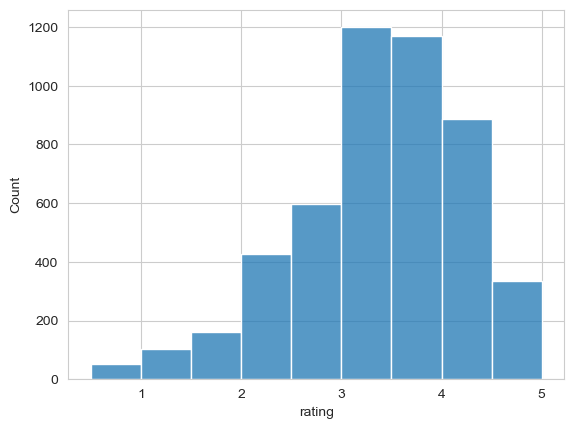

In [28]:
sns.histplot(data=avg_rating.to_frame(), x="rating", binwidth=0.5)

## 2. Filter out movies that have been watched by less than 20 users

In [29]:
filter = df.groupby("title")["userId"].count() < 20
less_than_20 = df.groupby("title")["userId"].count()[filter].sort_values()
len(less_than_20)

4145

In [30]:
f"{round(len(less_than_20) / df.nunique()[3], 2)}% of the movies have been rated by less then 20 users"

'0.84% of the movies have been rated by less then 20 users'

## 3. Get a list of movies with more than 100 ratings

In [31]:
most_rated_movies = df.groupby("title")["userId"].count().sort_values(ascending=False)
more_than_100 = most_rated_movies[most_rated_movies > 100]

In [32]:
with open('./data/full_df.bin', 'wb') as f:
    pickle.dump(df, f)

In [33]:
with open('./data/movie_dict.bin', 'wb') as f:
    pickle.dump(movie_dict, f)

In [34]:
with open('./data/more_than_100.bin', 'wb') as f:
    pickle.dump(more_than_100, f)